In [1]:
## Version futuresales lib required = 0.1.11

!pip install -i https://test.pypi.org/simple/ futuresales_denissimo==0.1.11
# !pip install plotly==5.3.1
# !pip install neptune-client
# !pip install neptune-sklearn

Looking in indexes: https://test.pypi.org/simple/
  Attempting uninstall: futuresales-denissimo
    Found existing installation: futuresales-denissimo 0.1.14
    Uninstalling futuresales-denissimo-0.1.14:
      Successfully uninstalled futuresales-denissimo-0.1.14


In [2]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

from tqdm._tqdm_notebook import tqdm_notebook
tqdm_notebook.pandas()

import futuresales as fs

from futuresales.distribution import from_pickle, to_pickle
from futuresales.utils import make_scaled, load_credentials
from futuresales.validation import Validator, causation_1_percent
from neptune.new.types import File

import seaborn as sns

/tmp/ipykernel_50949/1267431409.py:4: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.*` instead of `tqdm._tqdm_notebook.*`
  from tqdm._tqdm_notebook import tqdm_notebook


In [3]:
RUN_NAME = 'FSRES-22'

In [4]:
import neptune.new as neptune

cred = load_credentials('../../credentials.json')['projects']['fs-results']

run = neptune.init(
    api_token=cred['api_token'],
    project=cred['project'],
    run=RUN_NAME
)  # your credentials

Info (NVML): Driver Not Loaded. GPU usage metrics may not be reported. For more information, see https://docs-legacy.neptune.ai/logging-and-managing-experiment-results/logging-experiment-data.html#hardware-consumption 


https://app.neptune.ai/denissimo/FS-Results/e/FSRES-22
Remember to stop your run once you’ve finished logging your metadata (https://docs.neptune.ai/api-reference/run#stop). It will be stopped automatically only when the notebook kernel/interactive console is terminated.


In [5]:
task_df = {}

idx = pd.read_csv('../../tmp/idx.csv').rename({'id': 'object_id'}, axis=1)

task_df['test'] = pd.read_csv('../../tmp/task_df_test.csv').drop('Unnamed: 0', axis=1)
task_df['dynamic'] = from_pickle('../../tmp/id_sales_test.pkl')

In [6]:
run['dump/residuals'].download()
report = from_pickle('./residuals.pkl')
report['object_id'] = task_df['dynamic'].index
report['residuals'] = report['predicted'] - report['valid_target']

In [7]:
report

,valid_target,residuals,predicted,object_id
0,0.0,-0.002597,-0.002597,54
1,0.0,0.006256,0.006256,114
2,0.0,-0.002597,-0.002597,174
3,0.0,-0.002597,-0.002597,234
4,0.0,0.006256,0.006256,294
...,...,...,...,...
422572,0.0,0.004945,0.004945,1330036
422573,0.0,0.003700,0.003700,1330090
422574,0.0,0.003700,0.003700,1330142
422575,0.0,0.003700,0.003700,1330150


In [8]:
report = report.merge(idx, on='object_id', how='left')

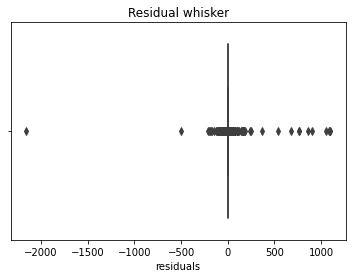

In [9]:
run['analysis/residuals/plots/whisker'].upload(File.as_image(sns.boxplot(data=report, x='residuals').set_title('Residual whisker').figure))

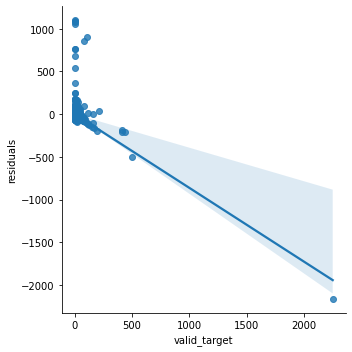

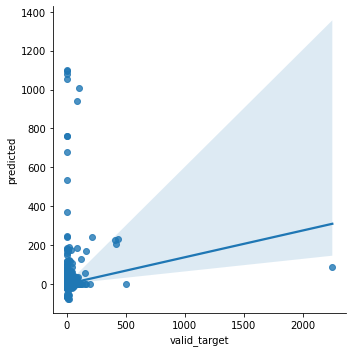

In [10]:
run['analysis/residuals/plots/dependecies'] = {
    'target_residual': File.as_image(sns.lmplot(data=report, x='valid_target', y='residuals').figure),
    'target_predicted': File.as_image(sns.lmplot(data=report, x='valid_target', y='predicted').figure),
}

In [11]:
stable_residual_interval = report.reset_index().rename(columns={'index': 'id'}).merge(idx)
stable_residual_interval['abs_residuals'] = abs(stable_residual_interval['residuals'])

In [12]:
giant_test, percent_str =  causation_1_percent(stable_residual_interval)

0.1% of objects cause 0.990468836159068 of error


In [13]:
giant_test

,id,valid_target,residuals,predicted,object_id,Unnamed: 0,item_name,item_id,item_category_id,shop_name,shop_id,item_category_name,abs_residuals,part
205261,205261,19.0,-14.819257,4.180743,531942,531942,"X Rebirth [PC, английская версия]",7872,30,"СПб ТК ""Невский Центр""",42,Игры PC - Стандартные издания,14.819257,0.000015
342859,342859,15.0,-14.853026,0.146974,1068085,1068085,"Assassin's Creed: Синдикат. Чаринг-Кросс [PS4,...",1586,20,"Москва ТРК ""Атриум""",25,Игры - PS4,14.853026,0.000015
420009,420009,0.0,14.946987,14.946987,1317282,1317282,"Билет ""ИгроМир 2015"" - 3 октября 2015 [Цифрова...",9250,80,"СПб ТК ""Невский Центр""",42,Служебные - Билеты,14.946987,0.000015
421380,421380,16.0,-15.135720,0.864280,1324089,1324089,Комикс Росомаха Старик Логан,13294,47,Выездная Торговля,9,"Книги - Комиксы, манга",15.135720,0.000016
215652,215652,11.0,-15.223213,-4.223213,557802,557802,"FIFA 16 [Xbox 360, русская версия]",3352,23,"СПб ТК ""Невский Центр""",42,Игры - XBOX 360,15.223213,0.000016
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
419943,419943,0.0,1052.452393,1052.452393,1316755,1316755,"Билет ""ИгроМир 2015"" - 2 октября 2015 (сайт) У...",9245,8,Цифровой склад 1С-Онлайн,55,Билеты (Цифра),1052.452393,0.076006
419950,419950,0.0,1082.601440,1082.601440,1317072,1317072,"Билет ""ИгроМир 2015"" - 2 октября 2015 (сайт) [...",9244,80,Интернет-магазин ЧС,12,Служебные - Билеты,1082.601440,0.080423
419983,419983,0.0,1095.580322,1095.580322,1317192,1317192,"Билет ""ИгроМир 2015"" - 3 октября 2015 (сайт) [...",9248,80,Интернет-магазин ЧС,12,Служебные - Билеты,1095.580322,0.082363
419945,419945,0.0,1098.528809,1098.528809,1316875,1316875,"Билет ""ИгроМир 2015"" - 3 октября 2015 (сайт) У...",9249,8,Цифровой склад 1С-Онлайн,55,Билеты (Цифра),1098.528809,0.082807


In [14]:
run['analysis/residuals/top_worst/magic_string'] = percent_str
run['analysis/residuals/top_worst/raw_giants'].upload(File.as_pickle(giant_test))


serieses = task_df['test'].groupby(['month_block', 'id']).item_cnt_day.sum().reset_index().set_index('id').index.value_counts().reset_index().rename({'id': 'appearence', 'index': 'id'}, axis=1)

In [15]:
top_50 = (giant_test.sort_values('part').reset_index()
    .groupby([
        'object_id', 'shop_id', 'item_id', 'shop_name', 'item_name'])
    .agg({
        'predicted': [np.mean],
        'valid_target': [np.mean], 
        'part': [np.mean], 
        'abs_residuals': [np.mean, lambda x: np.mean(x)**2]})
    .sort_values(('part', 'mean'))
    .tail(50)
    )
run['analysis/residuals/top_worst/top_50_objects'].upload(File.as_html(top_50))

In [16]:
top_15_shops = (giant_test.sort_values('part')
    .groupby([
        'shop_id', 'shop_name'])
    .agg({
        'part': [np.sum], 
        'abs_residuals': [np.sum]})
    .sort_values(('part', 'sum'))
    .tail(15))
run['analysis/residuals/top_worst/top_15_shops'].upload(File.as_html(top_15_shops))

In [17]:
top_15_items= (giant_test.sort_values('part')
    .groupby([
        'item_id', 'item_name'])
    .agg({
        'part': [np.sum], 
        'abs_residuals': [np.sum]})
    .sort_values(('part', 'sum'))
    .tail(15))
run['analysis/residuals/top_worst/top_15_items'].upload(File.as_html(top_15_items))

In [18]:
top_50.reset_index().set_index('object_id')

shop_id item_id                              shop_name  \
                                                                   
object_id                                                          
1317268        28    9250        Москва ТЦ "МЕГА Теплый Стан" II   
1317391        31    9254                Москва ТЦ "Семеновский"   
1073128        28    4721        Москва ТЦ "МЕГА Теплый Стан" II   
528429          9    7018                      Выездная Торговля   
1076125        25    7224                    Москва ТРК "Атриум"   
475771         31    3350                Москва ТЦ "Семеновский"   
1087705        25   15067                    Москва ТРК "Атриум"   
1244541        21   20949                 Москва МТРЦ "Афи Молл"   
1073251        31    4840                Москва ТЦ "Семеновский"   
1071266        26    3445            Москва ТЦ "Ареал" (Беляево)   
1244559        39   20949  РостовНаДону ТРК "Мегацентр Горизонт"   
1317266        26    9250            Москва ТЦ "Ареал" (Беляево)   
1076905        25   10202                    Москва ТРК "Атриум"   
525789          9    6503                      Выездная Торговля   
1071141        21    3351                 Москва МТРЦ "Афи Молл"   
1073262        42    4840                 СПб ТК "Невский Центр"   
1076922        42   10202                 СПб ТК "Невский Центр"   
1071142        22    3351                     Москва Магазин С21   
1321220        20   13246                    Москва "Распродажа"   
1287849         9   16843                      Выездная Торговля   
557791         31    3352                Москва ТЦ "Семеновский"   
1317151        31    9246                Москва ТЦ "Семеновский"   
1065282        42   10201                 СПб ТК "Невский Центр"   
1073131        31    4721                Москва ТЦ "Семеновский"   
1317385        25    9254                    Москва ТРК "Атриум"   
1065265        25   10201                    Москва ТРК "Атриум"   
557785         25    3352                    Москва ТРК "Атриум"   
520002         42    4719                 СПб ТК "Невский Центр"   
1317271        31    9250                Москва ТЦ "Семеновский"   
1073142        42    4721                 СПб ТК "Невский Центр"   
1073292        12    4843                    Интернет-магазин ЧС   
1244551        31   20949                Москва ТЦ "Семеновский"   
900009          9    4201                      Выездная Торговля   
1244545        25   20949                    Москва ТРК "Атриум"   
1244562        42   20949                 СПб ТК "Невский Центр"   
1317145        25    9246                    Москва ТРК "Атриум"   
1317265        25    9250                    Москва ТРК "Атриум"   
1316815        55    9247               Цифровой склад 1С-Онлайн   
1244532        12   20949                    Интернет-магазин ЧС   
1316935        55    9251               Цифровой склад 1С-Онлайн   
1317055        55    9255               Цифровой склад 1С-Онлайн   
1316995        55    9253               Цифровой склад 1С-Онлайн   
1317312        12    9252                    Интернет-магазин ЧС   
1244576        56   20949                   Чехов ТРЦ "Карнавал"   
1244577        57   20949                Якутск Орджоникидзе, 56   
1316755        55    9245               Цифровой склад 1С-Онлайн   
1317072        12    9244                    Интернет-магазин ЧС   
1317192        12    9248                    Интернет-магазин ЧС   
1316875        55    9249               Цифровой склад 1С-Онлайн   
1317972        12   11373                    Интернет-магазин ЧС   

                                                   item_name    predicted  \
                                                                     mean   
object_id                                                                   
1317268    Билет "ИгроМир 2015" - 3 октября 2015 [Цифрова...    80.250893   
1317391    Билет "ИгроМир 2015" - 4 октября 2015 [Цифрова...    82.925034   
1073128             

{1317192, 1316875, 1317072, 1316755, 1317972}
{1317312, 1244577, 1244576, 1316995, 1317055}
{1316935, 1316815, 1317265, 1244532, 1317145}
{1244545, 1244551, 900009, 1073292, 1244562}
{520002, 1065265, 1073142, 1317271, 557785}
{1065282, 1317385, 1073131, 557791, 1317151}
{1321220, 1071142, 1287849, 1073262, 1076922}
{1071141, 1076905, 1244559, 1317266, 525789}
{1071266, 1073251, 1087705, 475771, 1244541}
{1073128, 528429, 1317391, 1317268, 1076125}


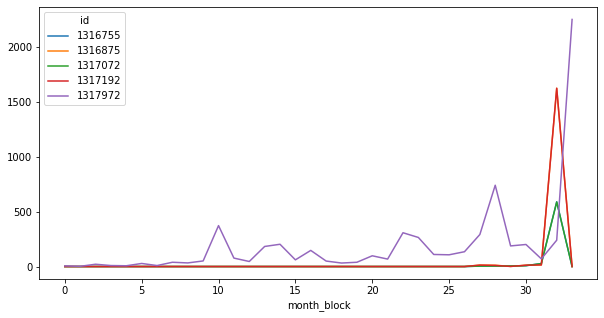

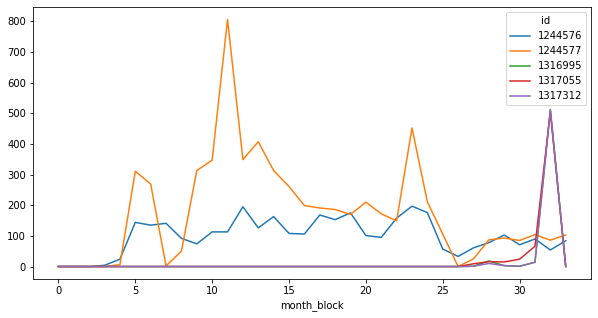

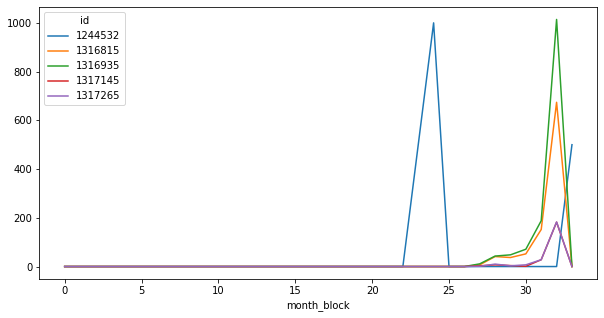

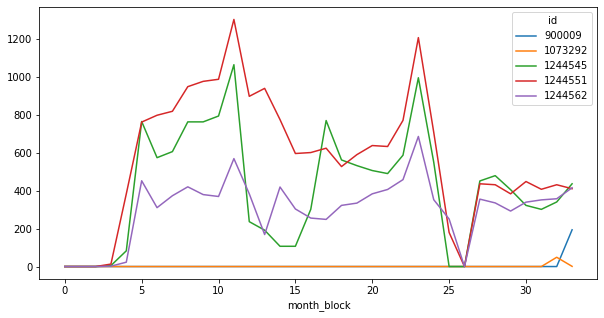

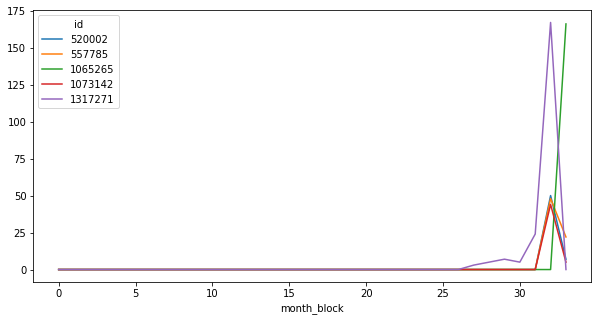

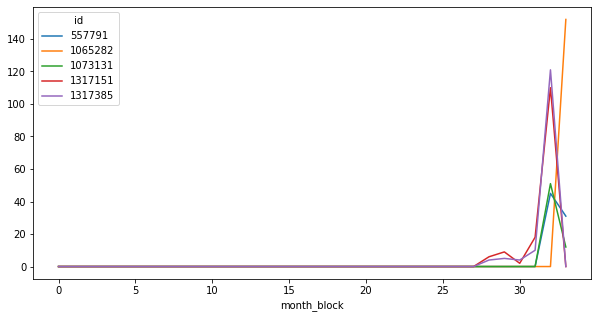

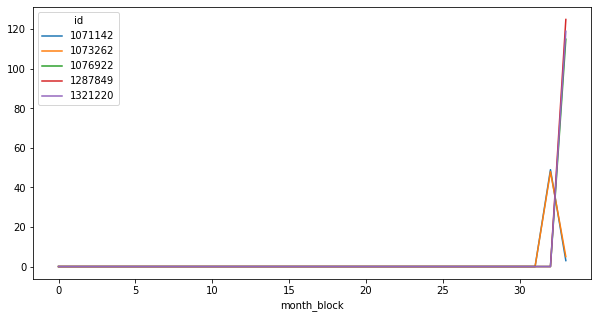

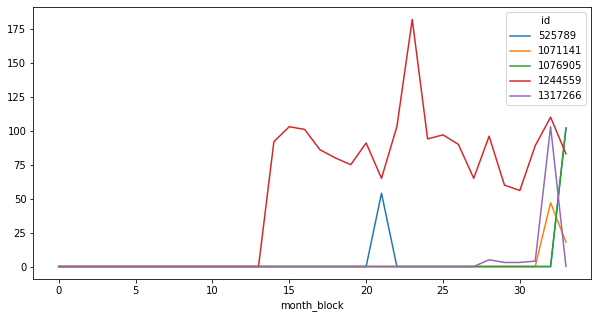

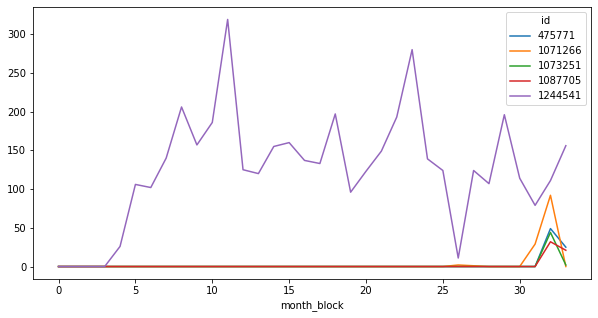

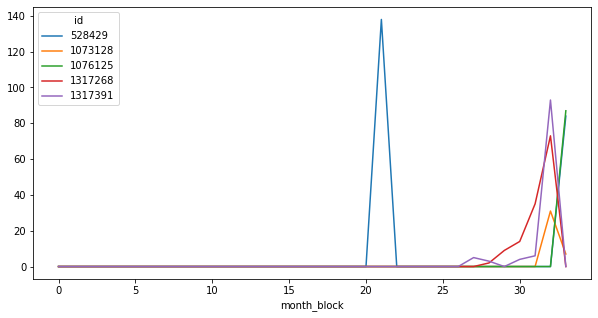

In [19]:
for i in range(0, 10):
    id_slice = top_50.reset_index().set_index('object_id').index.to_list()[-5 - 5*i: -5 - 5*(i - 1)] if i != 0 else top_50.reset_index().set_index('object_id').index.to_list()[-5: None]
    print(set(id_slice) & set(task_df['dynamic'].index))
    fig = task_df['dynamic'][task_df['dynamic'].index.isin(id_slice)].transpose().plot(figsize=(10, 5)).figure
    run[f'analysis/residuals/plots/top_{5*i}-{5*(i + 1)}_items'].upload(File.as_image(fig))

In [20]:
run.stop()

Shutting down background jobs, please wait a moment...
Done!


Waiting for the remaining 34 operations to synchronize with Neptune. Do not kill this process.


All 34 operations synced, thanks for waiting!
